In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import TransformerEncoderLayer, TransformerEncoder
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
import seaborn as sns
import matrixprofile as mp
from sklearn.decomposition import PCA

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')

Using cuda


In [3]:
print("FlashAttention available:", torch.backends.cuda.flash_sdp_enabled())

FlashAttention available: True


In [4]:
data = pd.read_csv('data.csv').to_numpy()
data = (data - data.mean(axis=1).reshape(-1, 1)) / data.std(axis=1).reshape(-1, 1)

In [5]:
train_length = round(len(data) * 0.8)

train_data = torch.tensor(data[:train_length], dtype=torch.float32)
test_data = torch.tensor(data[train_length:], dtype=torch.float32)
all_data = torch.tensor(data, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(train_data), batch_size=16, shuffle=True)
test_loader = DataLoader(TensorDataset(test_data), batch_size=16, shuffle=False)
all_loader = DataLoader(TensorDataset(all_data), batch_size=16, shuffle=True)

In [6]:
class TransformerAE(nn.Module):
    def __init__(self, input_dim, seq_length, d_model=128, nhead=4, num_layers=3, bottleneck_dim=48):
        super(TransformerAE, self).__init__()
        
        self.seq_length = seq_length
        self.d_model = d_model
        
        self.input_proj = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        self.bottleneck = nn.Linear(seq_length * d_model, bottleneck_dim)
        self.bottleneck_decoder = nn.Linear(bottleneck_dim, seq_length * d_model)
        
        decoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.decoder = nn.TransformerEncoder(decoder_layer, num_layers=num_layers)
        
        self.output_proj = nn.Linear(d_model, input_dim)
        
    def encode(self, x):
        x = self.input_proj(x)
        x = self.encoder(x)
        x = x.flatten(start_dim=1)
        x = self.bottleneck(x)
        return x
    
    def decode(self, x):
        x = self.bottleneck_decoder(x)
        x = x.unflatten(1, (self.seq_length, self.d_model))
        x = self.decoder(x)
        x = self.output_proj(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
        

In [7]:
model = TransformerAE(input_dim=48, d_model=64, seq_length=31).to(device)

In [8]:
k = 0
for param in model.parameters():
    if param.requires_grad:
        k += torch.prod(torch.tensor(param.size()))
print(f'Model has {k} trainable parameters')

Model has 1885664 trainable parameters


In [9]:
optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [10]:
all_train_losses = []
train_losses = []
test_losses = []

In [11]:
epochs = 25

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in train_loader:
        
        batch = batch[0].unsqueeze(1).view(-1, 31, 48).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        all_train_losses.append(loss.item())
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')
    train_losses.append(avg_loss)
    
    model.eval()
    avg_test_loss = 0
    with torch.no_grad():
        for batch in test_loader:
            batch = batch[0].unsqueeze(1).view(-1, 31, 48).to(device)
            preds = model(batch)
            loss = criterion(preds, batch)
            
            avg_test_loss += loss.item()
    avg_test_loss /= len(test_loader)
    test_losses.append(avg_test_loss)
    print(f'Test Loss: {avg_test_loss:.4f}')

C:\ProgramData\anaconda3\envs\nir\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1, Loss: 0.5829
Test Loss: 0.4708
Epoch 2, Loss: 0.4774
Test Loss: 0.4603
Epoch 3, Loss: 0.4615
Test Loss: 0.4460
Epoch 4, Loss: 0.4445
Test Loss: 0.4283
Epoch 5, Loss: 0.4153
Test Loss: 0.3948
Epoch 6, Loss: 0.3880
Test Loss: 0.3742
Epoch 7, Loss: 0.3739
Test Loss: 0.3616
Epoch 8, Loss: 0.3615
Test Loss: 0.3554
Epoch 9, Loss: 0.3546
Test Loss: 0.3478
Epoch 10, Loss: 0.3471
Test Loss: 0.3428
Epoch 11, Loss: 0.3428
Test Loss: 0.3448
Epoch 12, Loss: 0.3405
Test Loss: 0.3385
Epoch 13, Loss: 0.3363
Test Loss: 0.3403
Epoch 14, Loss: 0.3346
Test Loss: 0.3341
Epoch 15, Loss: 0.3288
Test Loss: 0.3363
Epoch 16, Loss: 0.3270
Test Loss: 0.3398
Epoch 17, Loss: 0.3291
Test Loss: 0.3344
Epoch 18, Loss: 0.3245
Test Loss: 0.3294
Epoch 19, Loss: 0.3230
Test Loss: 0.3279
Epoch 20, Loss: 0.3156
Test Loss: 0.3262
Epoch 21, Loss: 0.3154
Test Loss: 0.3258
Epoch 22, Loss: 0.3115
Test Loss: 0.3258
Epoch 23, Loss: 0.3102
Test Loss: 0.3247
Epoch 24, Loss: 0.3091
Test Loss: 0.3235
Epoch 25, Loss: 0.3074
Te

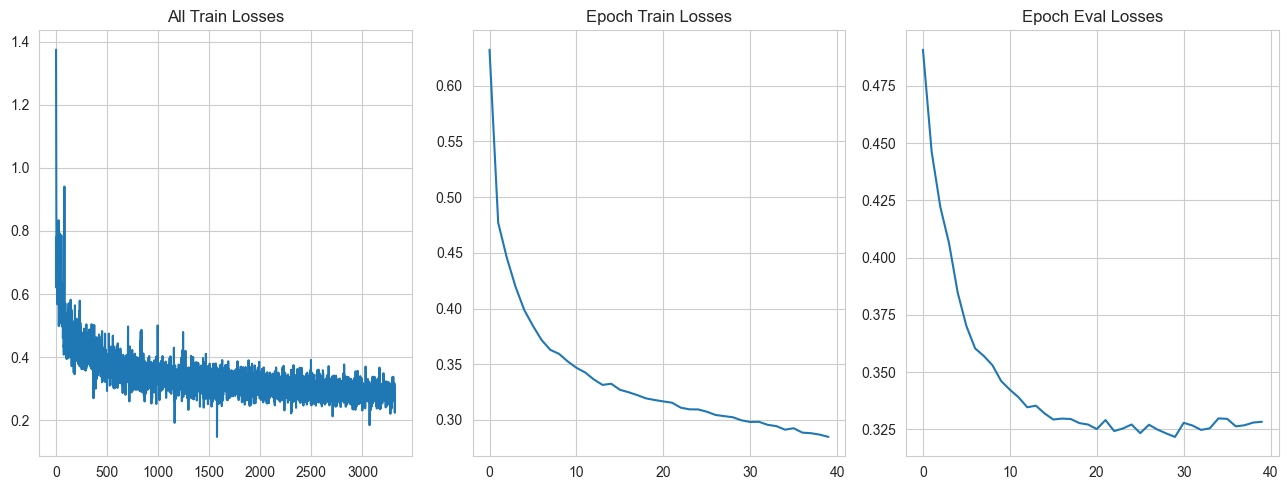

In [76]:
fig, axes = plt.subplots(1, 3, figsize=(13, 5))
axes[0].plot(all_train_losses)
axes[0].set_title('All Train Losses')
axes[1].plot(train_losses)
axes[1].set_title('Epoch Train Losses')
axes[2].plot(test_losses)
axes[2].set_title('Epoch Eval Losses')
plt.tight_layout()
plt.show()

In [77]:
model = TransformerAE(input_dim=48, d_model=128, seq_length=31).to(device)

optimizer = optim.AdamW(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()

In [78]:
epochs = 25

for epoch in range(epochs):
    avg_loss = 0
    model.train()
    for batch in all_loader:
        
        batch = batch[0].unsqueeze(1).view(-1, 31, 48).to(device)
        preds = model(batch)
        loss = criterion(preds, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    avg_loss /= len(train_loader)
    print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

Epoch 1, Loss: 0.6630
Epoch 2, Loss: 0.5705
Epoch 3, Loss: 0.5338
Epoch 4, Loss: 0.4859
Epoch 5, Loss: 0.4607
Epoch 6, Loss: 0.4393
Epoch 7, Loss: 0.4261
Epoch 8, Loss: 0.4140
Epoch 9, Loss: 0.4057
Epoch 10, Loss: 0.4024
Epoch 11, Loss: 0.3949
Epoch 12, Loss: 0.3906
Epoch 13, Loss: 0.3854
Epoch 14, Loss: 0.3793
Epoch 15, Loss: 0.3773
Epoch 16, Loss: 0.3724
Epoch 17, Loss: 0.3682
Epoch 18, Loss: 0.3667
Epoch 19, Loss: 0.3611
Epoch 20, Loss: 0.3569
Epoch 21, Loss: 0.3536
Epoch 22, Loss: 0.3493
Epoch 23, Loss: 0.3463
Epoch 24, Loss: 0.3429
Epoch 25, Loss: 0.3409


In [79]:
errors = []
encoded = []
reconstructed = []
with torch.no_grad():
    for sample in all_data:
        inputs = sample.view(-1, 31, 48).to(device)
        res = model(inputs).cpu().detach().flatten()
        reconstruction_error = criterion(res, sample)
        errors.append(reconstruction_error.cpu().detach().numpy())
        
        features = model.encode(inputs).view(-1)
        encoded.append(features.cpu().detach().numpy())
        
        reconstructed.append(res.view(-1).cpu().detach().numpy())
errors = np.array(errors)
encoded = np.array(encoded)
reconstructed = np.array(reconstructed)

In [83]:
def plot_sample(sample):
    _, ax = plt.subplots(figsize=(20, 5))
    ax.plot(data[sample], label='True Row')
    pred_row = reconstructed[sample]
    ax.plot(pred_row, label='Predicted Row')
    mse = np.linalg.norm(data[sample] - pred_row) ** 2 / len(data[sample])
    ax.set_title(f'Model Prediction VS True Row, MSE: {mse.round(2)}, Sample: {sample}')
    plt.legend()
    plt.show()

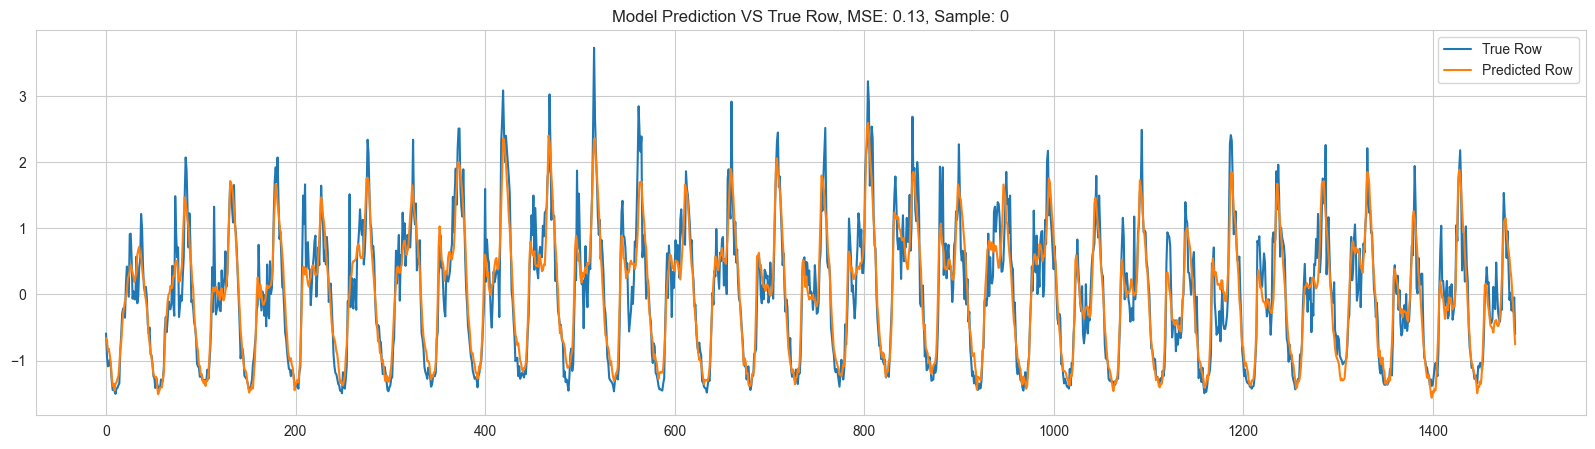

In [87]:
plot_sample(0)

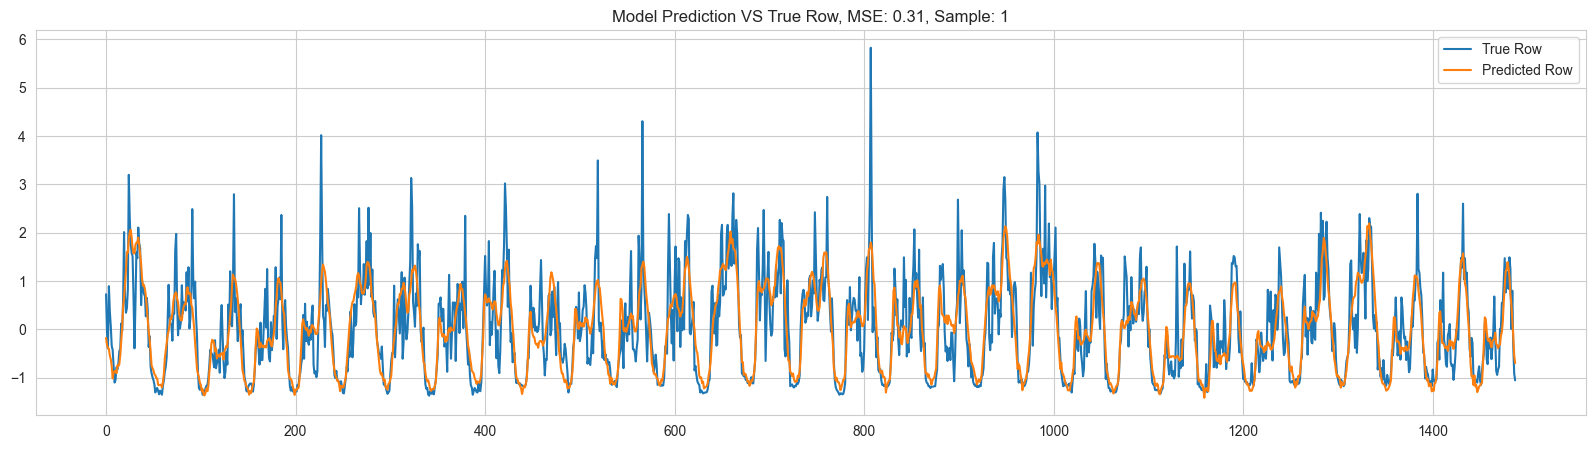

In [88]:
plot_sample(1)

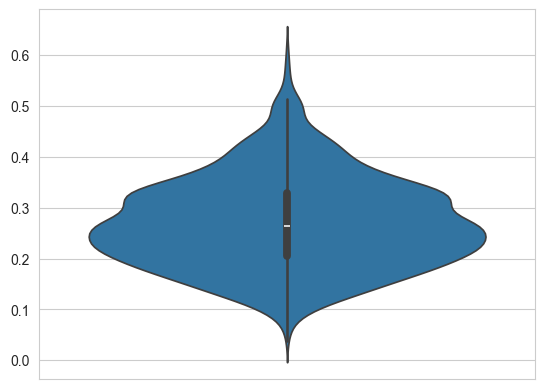

In [80]:
sns.violinplot(errors)
plt.show()

In [81]:
np.quantile(errors, 0.99)

0.5008144968748093

In [82]:
np.column_stack((np.argsort(-errors), -np.sort(-errors)))

array([[9.08000000e+02, 6.15415990e-01],
       [1.22500000e+03, 5.86658537e-01],
       [2.80000000e+01, 5.83461583e-01],
       ...,
       [1.10200000e+03, 6.38810471e-02],
       [1.09000000e+02, 6.24073334e-02],
       [2.23000000e+02, 3.73230278e-02]])

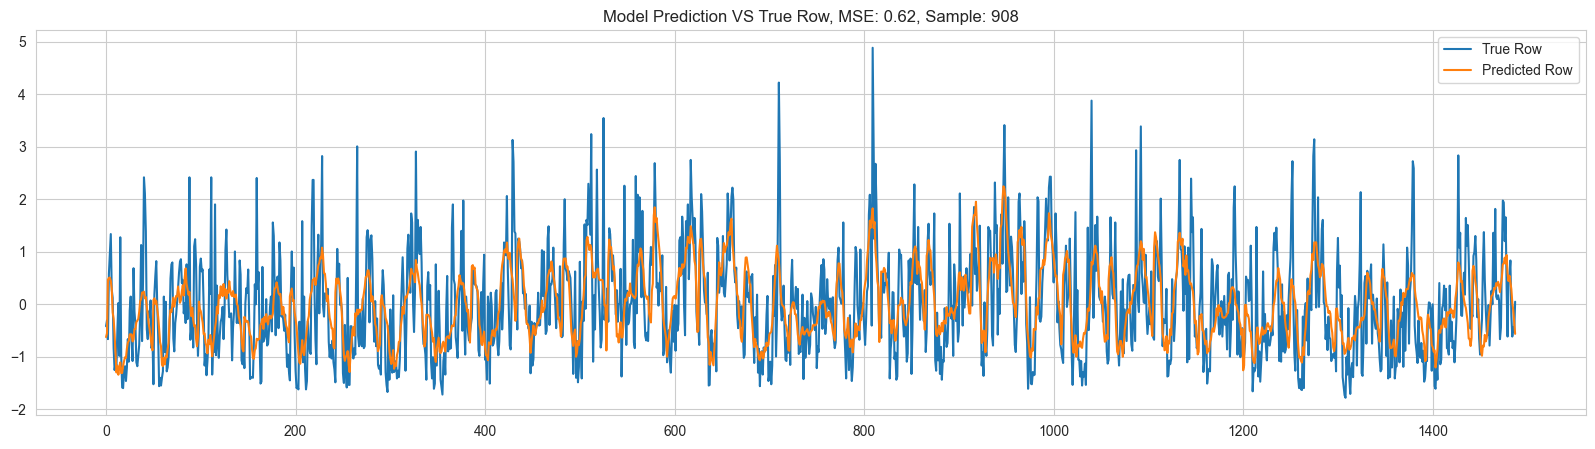

In [84]:
plot_sample(908)

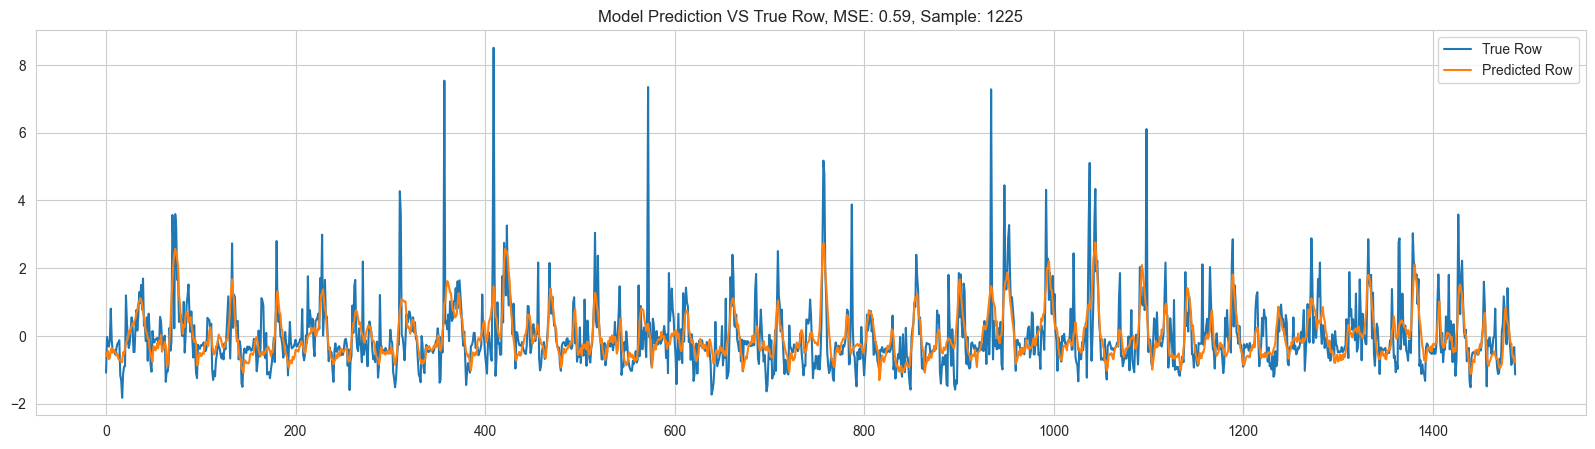

In [85]:
plot_sample(1225)

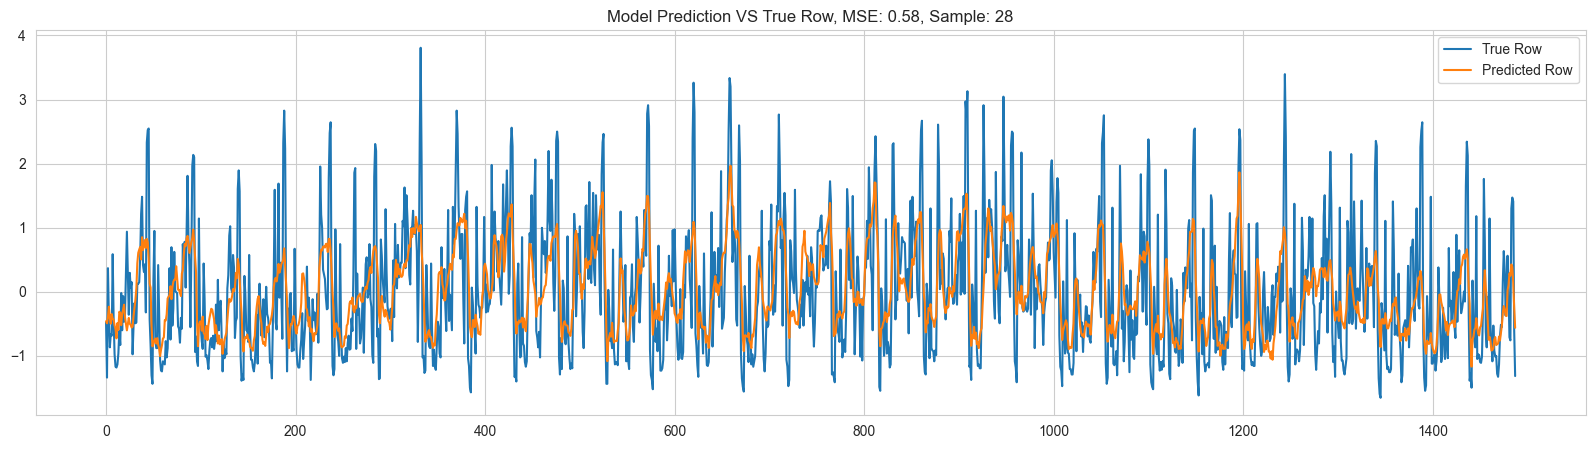

In [86]:
plot_sample(28)

In [89]:
# torch.save(model.state_dict(), './models/transformer_ae.pt')

In [90]:
encoded_norm = (encoded - encoded.mean(axis=0)) / encoded.std(axis=0)

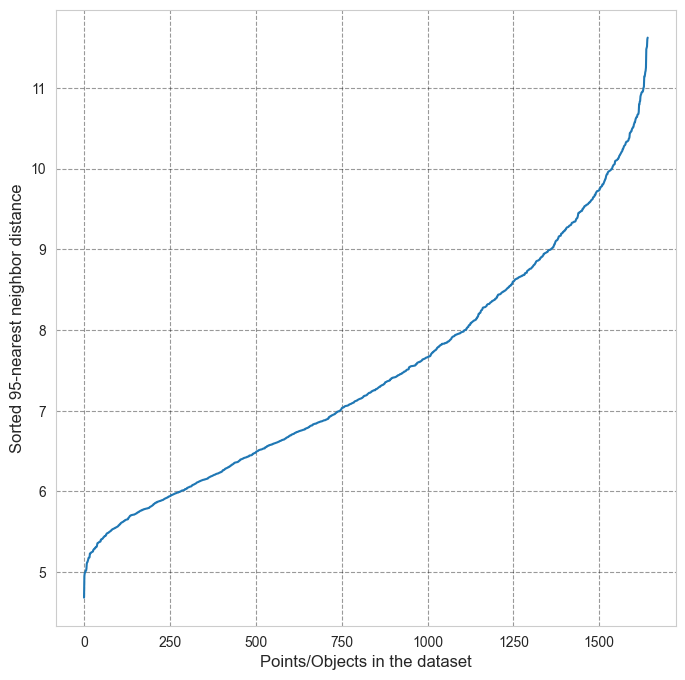

In [91]:
from sklearn.neighbors import NearestNeighbors


def get_kdist_plot(X=None, k=None, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.show()
    plt.close()


k = 2 * encoded_norm.shape[-1] - 1 # k=2*{dim(dataset)} - 1
get_kdist_plot(X=encoded_norm, k=k)

In [139]:
from sklearn.cluster import DBSCAN

# Создаем объект DBSCAN
dbscan = DBSCAN(eps=9.33, min_samples=30)

# Проводим кластеризацию данных
clusters = dbscan.fit_predict(encoded_norm)

# Ищем объекты, отнесенные к кластеру -1 (это аномалии)
anomalies_indices = np.where(clusters == -1)[0]
anomalies_indices

# 146, 1034, 1168

array([  56,  122,  146,  412,  543,  704,  950, 1034, 1119, 1168],
      dtype=int64)

In [140]:
anomalies_indices.reshape(-1, 1)

array([[  56],
       [ 122],
       [ 146],
       [ 412],
       [ 543],
       [ 704],
       [ 950],
       [1034],
       [1119],
       [1168]], dtype=int64)

In [141]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
encoded_pca = pca.fit_transform(encoded)
explained_variance = pca.explained_variance_ratio_

explained_variance

array([0.2003973 , 0.06379886], dtype=float32)

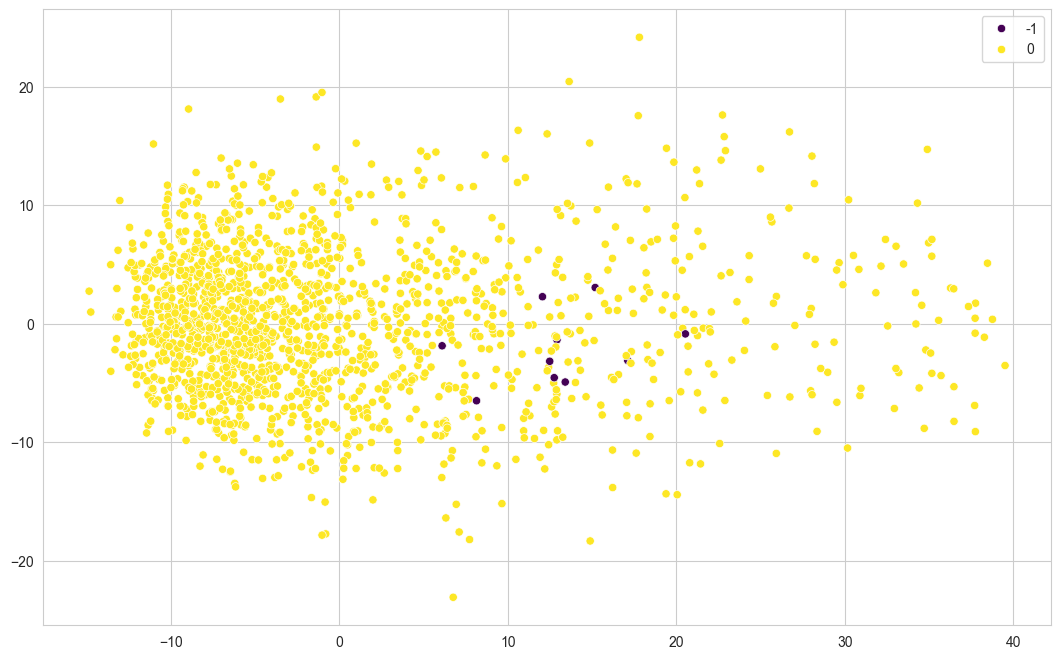

In [142]:
sns.scatterplot(x=encoded_pca[:, 0], y=encoded_pca[:, 1], hue=clusters, palette='viridis')
plt.gcf().set_size_inches(13, 8)
plt.show()

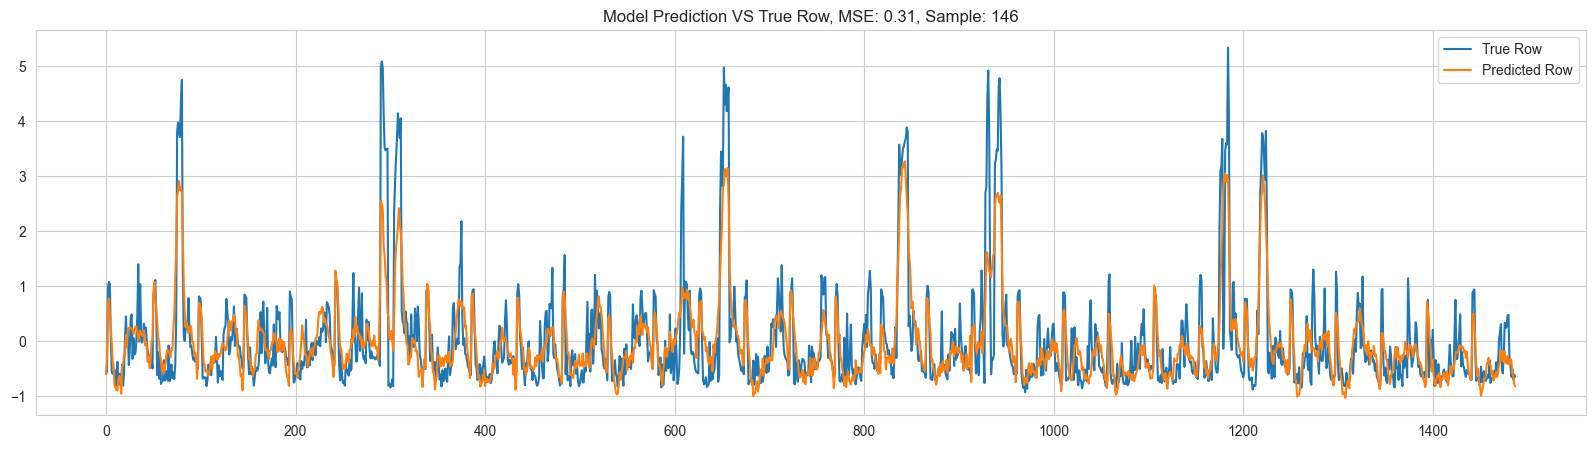

In [144]:
plot_sample(146)

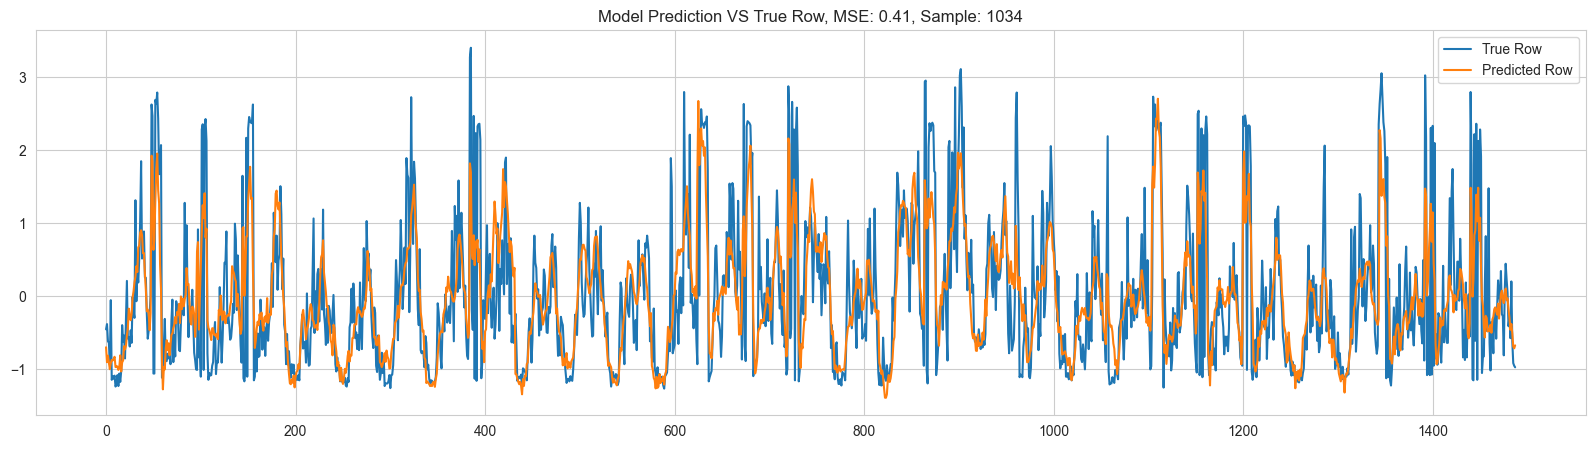

In [145]:
plot_sample(1034)

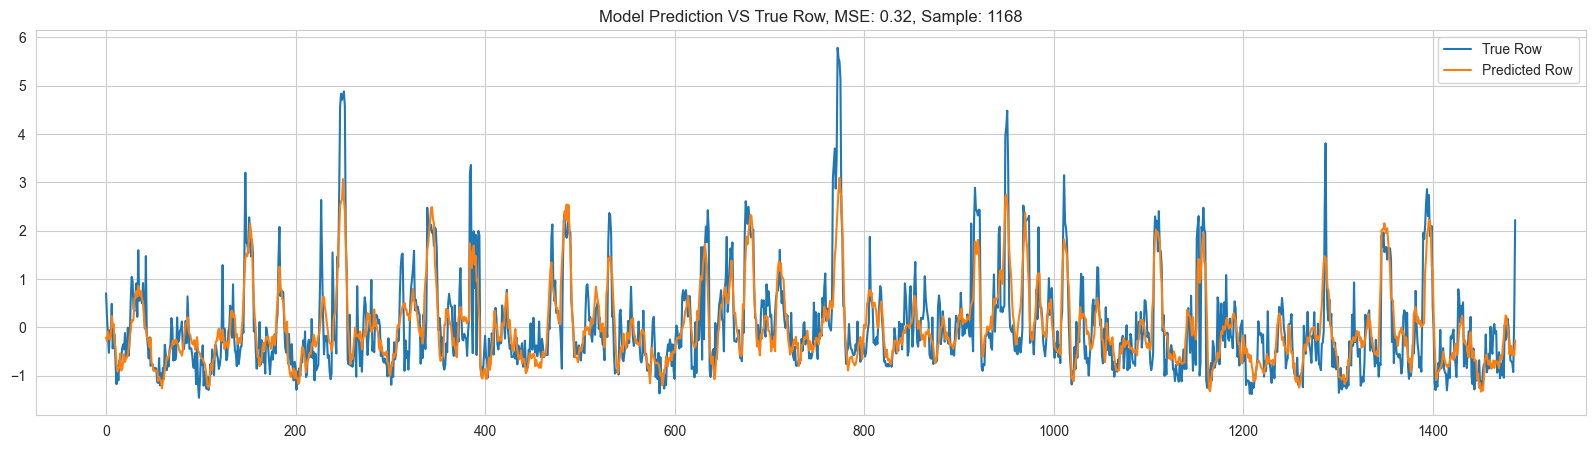

In [146]:
plot_sample(1168)

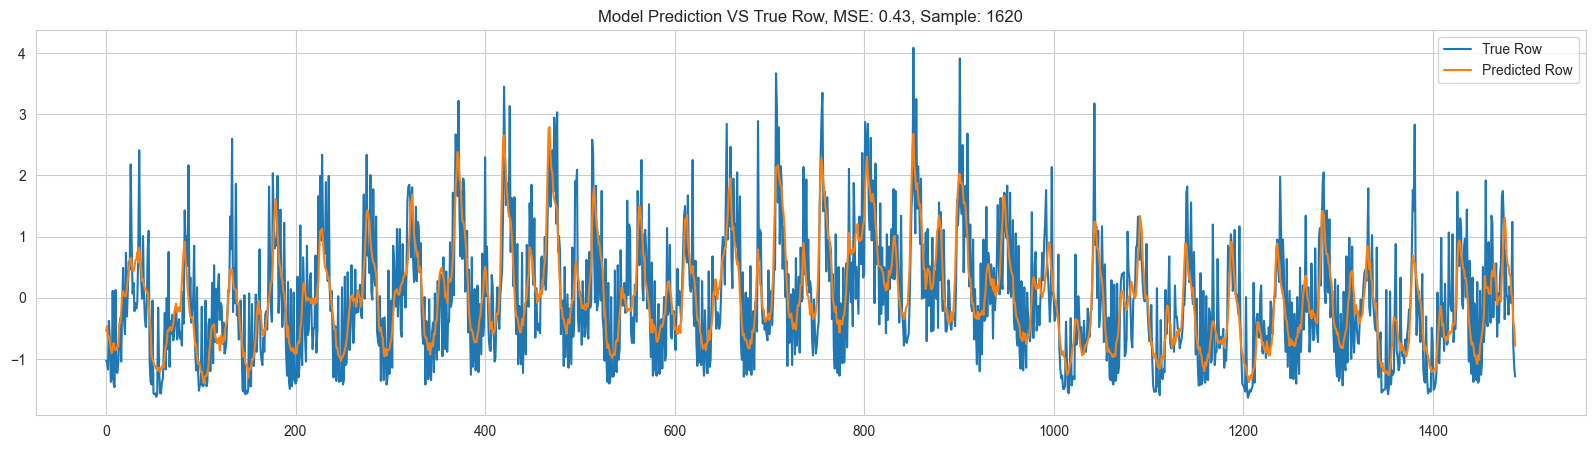

In [148]:
plot_sample(1620)